# Project: Dimensionality reduction

The project consists in reducing the dimensionality of a problem with small sample sizes. 8 data points are available, each associated to over 1650 possible predictors. The project aims at predicting a continuous target value of 8 provided samples.

This notebook is structured to reflect the modelling framework:
- Data exploration
- Data cleaning
- Visualisation
- Baseline modelling
- Model refinement

The framework steps are further detailed in the notebook. This notebook should be executed in a folder containing the provided dataset.

# 0. Import packages and data

## 0.1 Packages

In [1]:
# System
import os
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import numpy as np
import pandas as pd

# Visualisation
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('viridis')
colours = sns.color_palette('viridis', n_colors=8)

# Imputing
from sklearn.impute import SimpleImputer

# Pipeline
from sklearn.pipeline import Pipeline

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Decomposition
from sklearn.decomposition import PCA

# Modelling
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

# Model selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn.metrics import mean_absolute_error

 ## 0.2 Data

In [2]:
# The working directory to execute this code should be a folder containing both datasets provided
os.listdir('.')

['~$signment Data scientist chemistry.docx',
 'anonymised.csv',
 'dragon_molecular_descriptor_list.pdf',
 'devinyak2014.pdf',
 'dragon data of available SMILES.csv',
 'Anonymised.ipynb',
 'Data Scientist Chemometrics assignment.pptx',
 'Submission.py',
 'Submission.zip',
 'Predictive model.ipynb',
 'Submission.pdf',
 'ratio_vs_power.txt',
 '.ipynb_checkpoints',
 'Assignment Data scientist chemistry.docx',
 'Submission.ipynb',
 'Submission',
 'Regression model.ipynb',
 'Data Scientist Chemometrics assignment.pdf']

In [3]:
all_data = pd.read_csv('anonymised.csv', header=0)
all_data.set_index('Id', inplace=True)

# Cursory check of all data
print(f'DataFrame shape: {all_data.shape}')
all_data.head()

DataFrame shape: (4524, 1667)


,Feature0,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,...,Feature1657,Feature1658,Feature1659,Feature1660,Feature1661,Feature1662,Feature1663,Feature1664,Feature1665,Target
Id,,,,,,,,,,,,,,,,,,,,,
6309,154.28,5.32,15.89,28.28,17.31,24.92,0.55,0.98,0.60,2.27,...,0,0,1,0,-3.64,-3.83,-3.87,2.68,-2.51,NaN
7794,152.16,8.01,11.93,19.52,12.41,31.50,0.63,1.03,0.65,2.86,...,0,0,0,0,-2.17,-2.20,-2.15,1.31,-1.48,NaN
2767,122.18,6.43,11.50,18.75,12.26,20.67,0.61,0.99,0.65,2.30,...,0,0,0,0,-3.03,-3.15,-3.15,1.51,-1.03,NaN
3365,102.15,6.01,9.01,17.07,9.72,21.50,0.53,1.00,0.57,3.07,...,0,0,0,0,-2.24,-2.27,-2.23,1.26,-0.20,NaN
3733,128.14,7.54,9.93,17.52,10.41,26.83,0.58,1.03,0.61,2.98,...,0,0,0,0,-0.73,-0.58,-0.46,-0.33,0.54,NaN


In [4]:
dragon_df = pd.read_csv('dragon data of available SMILES.csv', sep=';', header=0, decimal=',')\
    .set_index('aroma_molecule_id')

slope_df = pd.read_csv('ratio_vs_power.txt', sep='\t', header=0)
slope_df.rename({' MoleculeId': 'MoleculeId'}, axis=1, inplace=True)
slope_df.set_index('MoleculeId', inplace=True)

dragon_data = dragon_df.join(slope_df, how='left')
dragon_data.drop(['MoleculeName', 'CAS', 'CanonicalSMILES', 'MOL_ID'], axis=1, inplace=True)
dragon_data.head()

,MW,AMW,Sv,Se,Sp,Ss,Mv,Me,Mp,Ms,...,Neoplastic-80,Neoplastic-50,Infective-80,Infective-50,BLTF96,BLTD48,BLTA96,ALOGPS_logP,ALOGPS_logS,Slope
aroma_molecule_id,,,,,,,,,,,,,,,,,,,,,
6309,154.28,5.32,15.89,28.28,17.31,24.92,0.55,0.98,0.60,2.27,...,0,0,1,0,-3.64,-3.83,-3.87,2.68,-2.51,NaN
7794,152.16,8.01,11.93,19.52,12.41,31.50,0.63,1.03,0.65,2.86,...,0,0,0,0,-2.17,-2.20,-2.15,1.31,-1.48,NaN
2767,122.18,6.43,11.50,18.75,12.26,20.67,0.61,0.99,0.65,2.30,...,0,0,0,0,-3.03,-3.15,-3.15,1.51,-1.03,NaN
3365,102.15,6.01,9.01,17.07,9.72,21.50,0.53,1.00,0.57,3.07,...,0,0,0,0,-2.24,-2.27,-2.23,1.26,-0.20,NaN
3733,128.14,7.54,9.93,17.52,10.41,26.83,0.58,1.03,0.61,2.98,...,0,0,0,0,-0.73,-0.58,-0.46,-0.33,0.54,NaN


In [5]:
dragon_data.mean(axis=0)

MW             160.593521
AMW              6.401521
Sv              15.272239
Se              26.557896
Sp              16.581788
                  ...    
BLTD48          -3.614613
BLTA96          -3.645241
ALOGPS_logP      3.700424
ALOGPS_logS     -1.984430
Slope            0.693550
Length: 1667, dtype: float64

In [6]:
all_data.mean(axis=0)

Feature0       160.593521
Feature1         6.401521
Feature2        15.272239
Feature3        26.557896
Feature4        16.581788
                  ...    
Feature1662     -3.614613
Feature1663     -3.645241
Feature1664      3.700424
Feature1665     -1.984430
Target           0.693550
Length: 1667, dtype: float64

In [7]:
features = [f'Feature{i}' for i in range(dragon_data.shape[1]-1)]
features.append('Target')
features = pd.Series(features)
dragon_data.columns = features
dragon_data.index.names = ['Id']
print(dragon_data.equals(all_data))
dragon_data.head()

True


,Feature0,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,...,Feature1657,Feature1658,Feature1659,Feature1660,Feature1661,Feature1662,Feature1663,Feature1664,Feature1665,Target
Id,,,,,,,,,,,,,,,,,,,,,
6309,154.28,5.32,15.89,28.28,17.31,24.92,0.55,0.98,0.60,2.27,...,0,0,1,0,-3.64,-3.83,-3.87,2.68,-2.51,NaN
7794,152.16,8.01,11.93,19.52,12.41,31.50,0.63,1.03,0.65,2.86,...,0,0,0,0,-2.17,-2.20,-2.15,1.31,-1.48,NaN
2767,122.18,6.43,11.50,18.75,12.26,20.67,0.61,0.99,0.65,2.30,...,0,0,0,0,-3.03,-3.15,-3.15,1.51,-1.03,NaN
3365,102.15,6.01,9.01,17.07,9.72,21.50,0.53,1.00,0.57,3.07,...,0,0,0,0,-2.24,-2.27,-2.23,1.26,-0.20,NaN
3733,128.14,7.54,9.93,17.52,10.41,26.83,0.58,1.03,0.61,2.98,...,0,0,0,0,-0.73,-0.58,-0.46,-0.33,0.54,NaN


In [8]:
dragon_data.compare(all_data)

Id


In [9]:
dragon_data.mean(axis=0)

Feature0       160.593521
Feature1         6.401521
Feature2        15.272239
Feature3        26.557896
Feature4        16.581788
                  ...    
Feature1662     -3.614613
Feature1663     -3.645241
Feature1664      3.700424
Feature1665     -1.984430
Target           0.693550
Length: 1667, dtype: float64

In [10]:
all_data.mean(axis=0)

Feature0       160.593521
Feature1         6.401521
Feature2        15.272239
Feature3        26.557896
Feature4        16.581788
                  ...    
Feature1662     -3.614613
Feature1663     -3.645241
Feature1664      3.700424
Feature1665     -1.984430
Target           0.693550
Length: 1667, dtype: float64

## 0.3 Extract modelling DataFrame

The modelling goal concerns only the lines in all_data where the Target column is not null.

In [11]:
# Get data with target value
target_data = all_data[all_data.Target.notnull()]

# Sanity check
print(f'Sub data shape: {target_data.shape}')
print(f'All data shape: {all_data.shape}')
print(f'All data with non-null Target shape: {all_data[all_data.Target.notnull()].shape}')
all_data[all_data.Target.notnull()].head(8)


Sub data shape: (8, 1667)
All data shape: (4524, 1667)
All data with non-null Target shape: (8, 1667)


,Feature0,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,...,Feature1657,Feature1658,Feature1659,Feature1660,Feature1661,Feature1662,Feature1663,Feature1664,Feature1665,Target
Id,,,,,,,,,,,,,,,,,,,,,
5605,116.18,5.81,10.61,19.96,11.48,20.67,0.53,1.00,0.57,2.58,...,0,0,0,0,-2.56,-2.62,-2.60,1.80,-0.99,0.6824
5637,144.24,5.55,13.81,25.72,15.00,23.67,0.53,0.99,0.58,2.37,...,0,0,0,0,-3.14,-3.28,-3.29,2.92,-2.09,0.7372
6187,130.21,5.66,12.21,22.84,13.24,22.50,0.53,0.99,0.58,2.50,...,0,0,0,0,-2.86,-2.96,-2.96,2.36,-1.80,0.7479
7891,136.26,5.24,14.78,25.07,16.09,16.58,0.57,0.96,0.62,1.66,...,0,0,0,0,-4.26,-4.53,-4.60,3.66,-2.94,0.2584
623,100.18,5.27,10.10,18.63,11.02,16.50,0.53,0.98,0.58,2.36,...,0,0,0,0,-2.62,-2.69,-2.67,1.69,-0.79,0.5759
3503,192.33,5.66,19.49,33.16,21.07,29.75,0.57,0.98,0.62,2.13,...,1,0,1,0,-3.94,-4.17,-4.23,4.11,-3.27,0.7274
3837,136.16,7.56,11.41,18.19,11.95,25.83,0.63,1.01,0.66,2.58,...,0,0,0,0,-2.66,-2.74,-2.72,1.64,-1.90,1.2339
4714,116.18,5.81,10.61,19.96,11.48,20.67,0.53,1.00,0.57,2.58,...,0,0,0,0,-2.56,-2.62,-2.60,1.84,-1.31,0.5853


# 1. Data exploration

## 1.1 Feature dropping

Given the very large number of features, visualisation is difficult or would be overly lengthy. However, some features can already be dropped at this stage:
* Any feature that is null in the sub dataset can be removed from datasets since it will bring no information for the model.

In [12]:
# Check missingness in target_data
target_data.isnull().sum()[target_data.isnull().sum() > 0]

Feature1545    8
Feature1580    8
Feature1605    8
Feature1613    8
Feature1614    8
Feature1621    8
Feature1622    8
Feature1623    8
Feature1624    8
Feature1625    8
Feature1626    8
Feature1627    8
Feature1628    8
Feature1629    8
Feature1630    8
Feature1631    8
Feature1632    8
Feature1633    8
Feature1634    8
dtype: int64

In [13]:
# Check for features that are missing
for feature in target_data.columns:
    if target_data[feature].isnull().sum() > 0:
        # Remove feature from both datasets
        target_data.drop(feature, axis=1, inplace=True)
        all_data.drop(feature, axis=1, inplace=True)

In [14]:
# Recheck missingness after feature deletion
target_data.isnull().sum()[target_data.isnull().sum() > 0]

Series([], dtype: int64)

In [15]:
# check all_data missingness after feature deletion
all_data.isnull().sum()[all_data.isnull().sum() > 0]

Feature279      27
Feature280      27
Feature281      27
Feature282      27
Feature283      27
Feature284      50
Feature285      50
Feature286      50
Feature287      50
Feature288      50
Feature289     101
Feature290     101
Feature291     101
Feature292     101
Feature293     101
Target        4516
dtype: int64

## 1.2 Target data

A cursory exploration of the target values can be performed at this stage. Selected features will be explored visually after data cleaning. The targets provided are quite similar, between 0.5 and 0.8, except for two samples for which they are significantly different, around 0.3 and 1.2 respectively.

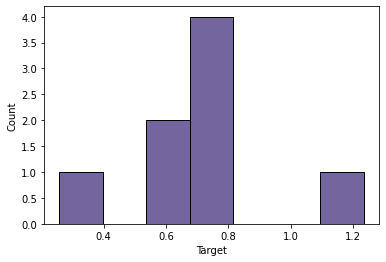

In [16]:
# Check distribution of available targets
sns.histplot(data=target_data, x='Target')
plt.show()

# 2. Data Cleaning

Data cleaning can include several steps. Each of these steps is tackled sequentially.
* Data Correction
* Data Completion
* Data Creation
* Data Conversion

## 2.1 Data Correction

Since the dataset provided was extracted from a single database, it is assumed there is no further missing data than the entries that were flagged as "#N/A" and converted automatically to np.nan by pd.read_csv. Any sparse features for which most values are 0 will be assumed to be correct (it will be assumed that 0 is an actual value and not a placeholder for missing data). No Data Correction is therefore required for this dataset.

## 2.2 Data Completion

After dropping features for which all values are null in the sub_data dataset (see step 1.1), there only remain missing values in the all_data dataset. Since this dataset is less critical than sub_data, these values will be imputed using a simple median imputer as to not assume the distribution of the features.

In [17]:
# Get numerical features of all_data
numericals = all_data.select_dtypes(include=np.number).columns.to_list()

# Apply SimpleImputer to numerical features in all_data
si = SimpleImputer(strategy='median', copy=True)
all_data[numericals] = si.fit_transform(all_data[numericals])

# Check missingness after imputing
all_data.isnull().sum()[all_data.isnull().sum() > 0]

Series([], dtype: int64)

## 2.3 Data Creation

Given the large number of features, no new features will be created from the data, at least at this point. Feature reduction techniques will be used further in the project to reduce the dimensionality of the problem.

## 2.4 Data Conversion

Some models only accept numerical parameters as input, and any categorical or boolean features should then be converted to numeric features, e.g. using pd.get_dummies. As can be seen below, there are no non-numeric predictors in the dataset.

In [18]:
# Check non-numeric columns in all_data
non_numeric = all_data.select_dtypes(exclude=np.number).columns.to_list()
print(non_numeric)

[]


# 3. Visual exploration

Visual exploration was performed as part of this project. However, visual exploration requires having knowledge on the features, targets and samples which is not provided in this anonymised dataset. For this reason, this section is removed from this public notebook.

Visual exploration included scatter plots and KDE plots of selected features expected to have an impact on the target value to assess whether relations were already visible.

# ----------------------
# Modelling strategy
# ----------------------

## On fitting with a large number of parameters

In this problem, we have 8 data points, and over 1600 possible predictors: just like it is possible to fit any curve by increasing the order of the equation (and thus the number of parameters), we could fit this dataset almost to perfection by tuning and optimising the 1600 parameters we have at our disposal, the weights of each predictor. However, such a model, while extremely efficient at reproducing measured data, would perform very poorly when applied for prediction of the target value for new samples, and would furthermore not bring any explainability. This is not a requirement of the current problem, but it is a direct result of the lack of meaning this model would have, just like a 1600th order polynomial.

The best model is generally the simplest model that manages to capture the true variability in the data, without capturing the noise. This could be measurement uncertainty, personal preferences, ... Depending on the application.

As a result, the goal of this problem should not be to fit as best as possible, but rather to find the simplest model that is able to capture its variance without its very specific particularities. Aka, avoid overfitting.

## On overfitting in small samples

This being said, it is highly likely that any model we obtain would be overfit because we have only 8 data points. In addition, along these data points, we have half of the samples that are very similar, and the other half that each have their own specifics \[Not shown part of the visual exploration of section 3\]. Furthermore, two of the samples exhibit what we could call at this scale outlier targets. Therefore, even using cross validation means any model not trained to these specifics will be very poor at predicting their targets, but most models should be able to predict the targets of the 4 similar samples.

If the dimensionality of the problem is its challenge, its limitation is sampling. A model can only perform well if it had been fitted, or trained, using a sample that is representative of the population. Here, this is certainly not the case as the full database (what we could consider the population in this case) contains over 4500 "lines" of predictors.

In conclusion, any model we build will be overfit to the samples compared to unseen samples, and the goal of the assignment cannot be predicting new target values because of this.

## On not using train_test_split

Given the small size and more importantly the diversity of the samples contained in the dataset, the dataset will not be split for this modelling exercise, e.g. using sklearn's train_test_split function. The reasoning behind this take is take is that every sample in the dataset is valuable for building the model since in most cases only 1 of the samples contains certain peculiarities.

## On the metric used for model performance

Since train_test_split will not be used, a different metric for model selection is used: the mean absolute error resulting from 8-fold cross-validation of each model using sklearn's cross_val_score. Computing 8-fold cross-validation on a sample size of 8 comes down to fitting the model using 7 out of the 8 samples 8 times, each time leaving out a different sample and calculating the absolute error on the prediction for the left-out sample. The mean of these 8 mean absolute errors is taken as an indicator of the ability of the model to have captured most of the variance provided in the sample without overfitting the pecularities of the 8 specific ones provided.

# 4. Baseline model

As a reference standard, a baseline model is fitted using all features. Since the target is a continuous numerical value, linear regression is used as a baseline model. As discussed above, this model will be severely overfitted to the data.

## 4.1 DataFrame formatting for modelling

Before fitting, the data is transformed to be ready for modelling.
* The X DataFrame contains all predictors, i.e. target_data
* The y DataFrame contains the target value.

In [19]:
X = target_data.drop(['Target'], axis=1, inplace=False)
y = target_data.Target

# Reproduce sample order compared to uncensored dataset for robustness
X = X.reindex(index=[3837, 6187, 5637, 3503, 5605, 4714, 623, 7891])
y = y.reindex(index=[3837, 6187, 5637, 3503, 5605, 4714, 623, 7891])

Eech model will follow the same structure:
* Initialisation of the different tools
* Fitting
* Predicting
* Computing metrics (model MAE and 8-fold cross-validation MAE)

## 4.2 Simple linear regression

As expected, given the large number of predictors provided, the prediction is practically exact. It is highly likely that such a model is severely overfitted to the 8 examples provided. This is confirmed by the very low model MAE and the very high CV average MAE obtained of roughly 0.78.

In [20]:
# Initialisation
name_lr = 'lr'
lr = LinearRegression()

# Fitting
lr.fit(X, y)

# Predicting
preds = lr.predict(X)

# Metrics - MAE
mae_lr = mean_absolute_error(y, preds)

# Metrics - CV
cv_results = cross_val_score(lr, X, y, cv=8, scoring='neg_mean_absolute_error')
cv_lr = abs(cv_results).mean()

# Format metrics
metrics_lr = np.array([name_lr,'{:0.2e}'.format(mae_lr), '{:.2f}'.format(cv_lr)]).reshape((1, 3))

# Combine metrics in single df
metrics = pd.DataFrame(metrics_lr, columns=['model', 'MAE', 'CV_MAE']).set_index('model')

# Show results
print(metrics)

            MAE CV_MAE
model                 
lr     9.58e-16   0.78


## 4.3 Standardised simple linear regression

A StandardScaler is also used to normalize feature mean and standard deviation since linear regression models tend to be influenced by features on differring scales. Using the StandardScaler before simple linear regression significantly improves the CV MAE (by about twofold). However, the model remain severely overfitted since it still uses all predictors.

In [21]:
# Initialisation
name_lr_std = 'lr_std'
ss = StandardScaler()
lr_std = LinearRegression()
pipeline = Pipeline([('scaler', ss), ('linear_regression', lr_std)])

# Fitting
pipeline.fit(X, y)

# Predicting
preds_std = pipeline.predict(X)

# Metrics - MAE
mae_lr_std = mean_absolute_error(y, preds_std)

# Metrics - CV
cv_results_std = cross_val_score(pipeline, X, y, cv=8, scoring='neg_mean_absolute_error')
cv_lr_std = abs(cv_results_std).mean()

# Format metrics
metrics_lr_std = np.array([name_lr_std,'{:0.2e}'.format(mae_lr_std), '{:.2f}'.format(cv_lr_std)]).reshape((1, 3))

# Combine metrics in single df
if name_lr_std not in metrics.index:
    metrics = pd.concat([metrics, pd.DataFrame(metrics_lr_std, columns=['model', 'MAE', 'CV_MAE']).set_index('model')],
                        axis=0)

# Show results
print(metrics)

             MAE CV_MAE
model                  
lr      9.58e-16   0.78
lr_std  2.43e-16   0.32


## 4.4 Most important features without feature selection

Even though all descriptors were used in this baseline model, we can already get an idea of which features played a major role by examining the model coefficients. Note that we do not find any of the features we intuitively thought would be important in these top features \[Features were anonymised here, their interpretation is kept for reference\].

In [22]:
# Create DataFrame containing coefficients
coeffs = pd.DataFrame(zip(lr.coef_, lr_std.coef_),
                      columns=['Coefficients_lr', 'Coefficients_lr_std'],
                      index=X.columns)

# Get feature importance
coeffs['AbsCoefficients_lr'] = abs(coeffs.Coefficients_lr)
coeffs['AbsCoefficients_lr_std'] = abs(coeffs.Coefficients_lr_std)

# Get top features for both models
lr_important_features = coeffs.sort_values(by='AbsCoefficients_lr', ascending=False).head(20).index
lr_std_important_features = coeffs.sort_values(by='AbsCoefficients_lr_std', ascending=False).head(20).index

# Create DataFrame of top features
important_features = pd.DataFrame(zip(lr_important_features, lr_std_important_features),
                                  columns=['lr', 'lr_std'])

print(important_features)

            lr       lr_std
0   Feature185     Feature5
1    Feature66   Feature875
2    Feature88   Feature815
3    Feature77   Feature755
4    Feature64   Feature429
5    Feature86   Feature845
6   Feature116   Feature278
7   Feature692  Feature1287
8   Feature691   Feature785
9    Feature80     Feature4
10  Feature667   Feature414
11  Feature689   Feature399
12  Feature755  Feature1105
13  Feature597  Feature1285
14  Feature845  Feature1143
15  Feature595  Feature1061
16  Feature754   Feature998
17  Feature255  Feature1094
18  Feature750   Feature369
19  Feature844   Feature377


# 5. Dimensionality reduction

As discussed above, the goal of the exercise is to find the "best simplest model" to fit the targets. To that objective, two dimensionality reduction strategies will be explored: Principal Components Analysis (PCA) for performing feature reduction, and penalized regression using LASSO for feature selection.

## 5.1 PCA

### Exploratory PCA

First, the data is scaled and transformed using PCA to determine how many Principal Components (PC) capture most of the variability.

The StandardScaler is used since PCA is very sensitive to feature scale. Using PCA to perform dimensionality reduction on the target dataset (containing values for 8 samples) shows that >95% of the variance in the data can be captured by the 5 first principal components, while the 4 first components capture >90% of the variance in the dataset.

% of variance captured cumulatively by including more principal components:
 [0.43 0.67 0.83 0.91 0.96 0.98 0.99 0.99]


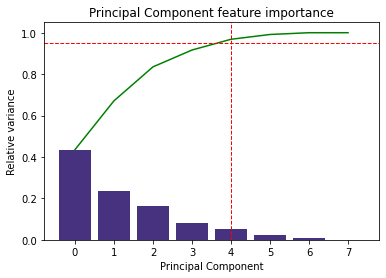

In [23]:
# Explore PCA: scale the data and create 8 principal components using PCA
X_scaled = StandardScaler().fit_transform(X)

# Fit maximum number of PCs
pca_expl = PCA(n_components=X_scaled.shape[0])
pca_features = pca_expl.fit_transform(X_scaled)

# Print cumulative sum of relative importance
print('% of variance captured cumulatively by including more principal components:\n',
      (pca_expl.explained_variance_/pca_expl.explained_variance_.sum()).round(2).cumsum())

# Plot relative variance explained by each added PCA feature and Pareto
plt.bar(range(pca_expl.n_components_), pca_expl.explained_variance_/pca_expl.explained_variance_.sum())
plt.plot((pca_expl.explained_variance_/pca_expl.explained_variance_.sum()).cumsum(), color='green')
plt.axhline(y=.95, color='red', linestyle='--', linewidth=1)
plt.axvline(x=4, color='red', linestyle='--', linewidth=1)
plt.title('Principal Component feature importance')
plt.ylabel('Relative variance')
plt.xlabel('Principal Component')
plt.show()

### Linear regression with 5 principal components

The result from the linear regression applying PCA wth 5 principal components is still very good at fitting the 8 targets provided, with a mean absolute target difference of 0.03. Cross-validation does not show significant improvement over the scaled simple linear regression.

The downside of using PCA is the loss of explainability of the observed relations, the most important features are therefore not explored as they were in the simple linear regression model.

In [24]:
# Initialisation
name_pca = 'lr_pca'
ss_pca = StandardScaler()
pca = PCA(n_components=5) # 5 components capture 95% of variance, see PCA exploration above
lr_pca = LinearRegression()
pipeline_pca = Pipeline([('scaler', ss_pca), ('pca', pca), ('linear_regression', lr_pca)])

# Fitting
pipeline_pca.fit(X, y)

# Predicting
preds_pca = pipeline_pca.predict(X)

# Metrics - MAE
mae_pca = mean_absolute_error(y, preds_pca)

# Metrics - CV
cv_results_pca = cross_val_score(pipeline_pca, X, y, cv=8, scoring='neg_mean_absolute_error')
cv_pca = abs(cv_results_pca).mean()

# Format metrics
metrics_pca = np.array([name_pca,'{:0.2e}'.format(mae_pca), '{:.2f}'.format(cv_pca)]).reshape((1, 3))

# Combine metrics in single df
if name_pca not in metrics.index:
    metrics = pd.concat([metrics, pd.DataFrame(metrics_pca, columns=['model', 'MAE', 'CV_MAE']).set_index('model')],
                        axis=0)

# Show results
print(metrics)

             MAE CV_MAE
model                  
lr      9.58e-16   0.78
lr_std  2.43e-16   0.32
lr_pca  2.94e-02   0.31


## 5.2 PCA using entire Feature dataset

Given the results observed in the previous section (no real difference between scaled linear regression using all features and scaled linear regression using PCA features), it will next be attempted to apply PCA to the ~4500 samples of the full feature dataset to extract variability, then apply these new principal components to the target dataset to assess whether this improves the results. The main idea behind this attempt is that the true variance may better be captured using more samples of the features, even if their target is unknown.

To do so, the all_data DataFrame is split in a similar fashion to the target_data DF, to extract the feature DataFrame X_all.

In [25]:
X_all = all_data.drop(['Target'], axis=1, inplace=False)

### Exploratory PCA

Over 95% of the variance is captured by including 160 principal components. However, we could achieve capturing >90% of variance by taking significantly less principal components, 95 in total.

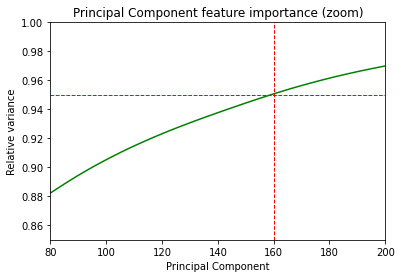

In [26]:
# Explore PCA: scale the data and create principal components using PCA
X_all_scaled = StandardScaler().fit_transform(X_all)

# Fit maximum number of PCs
pca_all_expl = PCA(n_components=min(X_all_scaled.shape))
pca_all_features = pca_all_expl.fit_transform(X_all_scaled)

# Plot relative variance explained by each added PCA feature and Pareto
plt.bar(range(pca_all_expl.n_components_), pca_all_expl.explained_variance_/pca_all_expl.explained_variance_.sum())
plt.plot((pca_all_expl.explained_variance_/pca_all_expl.explained_variance_.sum()).cumsum(), color='green')
plt.axhline(y=.95, color='red', linestyle='--', linewidth=1)
plt.axvline(x=160, color='red', linestyle='--', linewidth=1)
plt.title('Principal Component feature importance (zoom)')
plt.ylabel('Relative variance')
plt.xlabel('Principal Component')
# Zoom in on intersect region
plt.xlim([80, 200])
plt.ylim([.85, 1])
plt.show()

### Linear regression using PCs of all Feature samples

This strategy made the cross-validation score much worse, on the same level os the non-standardised simple linear regression model.

In [27]:
# Initialisation
name_pca_all = 'lr_pca_all'
ss_pca_all = StandardScaler()
pca_all = PCA(n_components=160)
lr_pca_all = LinearRegression()

# Fitting
# No pipeline is used since we apply the PC transformation fitted on all samples (X_all)
# to the 8 samples for which a target is provided (X)
pca_all.fit(ss_pca_all.fit_transform(X_all))
X_pca_allMols = pca.transform(ss_pca_all.transform(X))
lr.fit(X_pca_allMols, y)

# Predicting
preds_pca_all = lr.predict(X_pca_allMols)

# Metrics - MAE
mae_pca_all = mean_absolute_error(y, preds_pca_all)

# Metrics - CV
cv_results_pca_all = cross_val_score(lr, X_pca_allMols, y, cv=8, scoring='neg_mean_absolute_error')
cv_pca_all = abs(cv_results_pca_all).mean()

# Format metrics
metrics_pca_all = np.array([name_pca_all,'{:0.2e}'.format(mae_pca_all), '{:.2f}'.format(cv_pca_all)]).reshape((1, 3))

# Combine metrics in single df
if name_pca_all not in metrics.index:
    metrics = pd.concat([metrics, pd.DataFrame(metrics_pca_all, columns=['model', 'MAE', 'CV_MAE']).set_index('model')],
                        axis=0)

# Show results
print(metrics)

                 MAE CV_MAE
model                      
lr          9.58e-16   0.78
lr_std      2.43e-16   0.32
lr_pca      2.94e-02   0.31
lr_pca_all  2.86e-02   0.72


## 5.3 LASSO regression

There are two main regularization techniques for linear regression, called L1 and L2 regularization. By applying different penalization terms to the regression loss function, they aim at avoiding overfitting the model to the fitted dataset. The strategy applied is different for both regularization schemes. The end result:
* Under L1 regularization, the amplitude of the least important features weights is forced to 0 to avoid overfitting
* Under L2 regularization, the amplitude of all feature weights is scaled down to avoid overfitting

This means that among both regularization schemes, only L1 regularization performs feature selection. L1 regularization is the scheme implemented in the LASSO regressor (L2 regularization being implemented in Ridge regression). LASSO (Least Absolute Shrinkage and Selection Operator) regression will therefore be used to reduce the dimensionality of the problem and avoid overfitting.

### 5.3.1. Baseline LASSO model

The baseline LASSO model significantly improves the cross-validation MAE, but there still is an order of magnitude difference between the cross-validation MAE and the model MAE, which indicates that the model is still overfitted to the target data.

In [28]:
# Initialisation
name_lasso = 'lasso'
lasso = Lasso()

# Fitting
lasso.fit(X, y)

# Predicting
preds_lasso = lasso.predict(X)

# Metrics - MAE
mae_lasso = mean_absolute_error(y, preds_lasso)

# Metrics - CV
cv_results_lasso = cross_val_score(lasso, X, y, cv=8, scoring='neg_mean_absolute_error')
cv_lasso = abs(cv_results_lasso).mean()

# Format metrics
metrics_lasso = np.array([name_lasso,'{:0.2e}'.format(mae_lasso), '{:.2f}'.format(cv_lasso)]).reshape((1, 3))

# Combine metrics in single df
if name_lasso not in metrics.index:
    metrics = pd.concat([metrics, pd.DataFrame(metrics_lasso, columns=['model', 'MAE', 'CV_MAE']).set_index('model')],
                        axis=0)

# Show results
print(metrics)

                 MAE CV_MAE
model                      
lr          9.58e-16   0.78
lr_std      2.43e-16   0.32
lr_pca      2.94e-02   0.31
lr_pca_all  2.86e-02   0.72
lasso       2.58e-02   0.16


## 5.3.2 LASSO regression with standardisation

Aplying the StandardScaler before the LASSO regressor decreases the cross-validation MAE, but this is the first model for which the model MAE (that can be associated with the training set error) and the cross-validation MAE (that can be associated with the test set error) are close. This indicates that the LASSO regressor with standardization is the "best simplest model" found so far.

In [29]:
# Initialisation
name_lasso_std = 'lasso_std'
ss_lasso = StandardScaler()
lasso_std = Lasso()
pipeline_lasso_std = Pipeline([('scaler', ss_lasso), ('lasso', lasso_std)])

# Fitting
pipeline_lasso_std.fit(X, y)

# Predicting
preds_lasso_std = pipeline_lasso_std.predict(X)

# Metrics - MAE
mae_lasso_std = mean_absolute_error(y, preds_lasso_std)

# Metrics - CV
cv_results_lasso_std = cross_val_score(pipeline_lasso_std, X, y, cv=8, scoring='neg_mean_absolute_error')
cv_lasso_std = abs(cv_results_lasso_std).mean()

# Format metrics
metrics_lasso_std = np.array([name_lasso_std,'{:0.2e}'.format(mae_lasso_std), '{:.2f}'.format(cv_lasso_std)]).reshape((1, 3))

# Combine metrics in single df
if name_lasso_std not in metrics.index:
    metrics = pd.concat([metrics, pd.DataFrame(metrics_lasso_std, columns=['model', 'MAE', 'CV_MAE']).set_index('model')],
                        axis=0)

# Show results
print(metrics)

                 MAE CV_MAE
model                      
lr          9.58e-16   0.78
lr_std      2.43e-16   0.32
lr_pca      2.94e-02   0.31
lr_pca_all  2.86e-02   0.72
lasso       2.58e-02   0.16
lasso_std   1.68e-01   0.19


### 5.3.3 LASSO model feature importance

The most important features of both LASSO models are examined in comparison with the linear models important features. The baseline LASSO model only keeps 4 coefficients above 0 among the > 1600 possible predictors.

The standardised LASSO model shows only missing values. To check whether this is an error, the .coef_ and .intercept_ are examined below. From this check, it becomes clear that with standardised input predictors, the LASSO model sets all coefficients to 0 and only fits an intercept of roughly 0.69.

As a result, the LASSO regressor predicts that the "best simplest model" is actually just a constant. This is not useful for interpretability physical understanding.

In [30]:
# Initialize LASSO model names and link to regressor
lasso_names = {'lasso': lasso,
               'lasso_std': lasso_std}

# Append LASSO most important features to DataFrame created previously for linear regression models
for lasso_name in lasso_names:
    
    # Create temporary DataFrame with all feature importances for model
    feature_df = pd.DataFrame({'Feature': X.columns,
                              'Coefficient': lasso_names[lasso_name].coef_,
                              'Importance': abs(lasso_names[lasso_name].coef_)})

    # Avoid adding duplicate columns
    if lasso_name not in important_features.columns:
        # Add the most important non-null features of the LASSO model to the important_features df
        important_features = pd.concat([important_features,
                                        feature_df[feature_df.Importance > 0]
                                            .sort_values(by='Importance', ascending=False)
                                            .reset_index()
                                            .Feature
                                            .rename(lasso_name)],
                                       axis=1)

# See all important features for all models
print(important_features)

            lr       lr_std       lasso lasso_std
0   Feature185     Feature5   Feature66       NaN
1    Feature66   Feature875   Feature80       NaN
2    Feature88   Feature815  Feature667       NaN
3    Feature77   Feature755  Feature187       NaN
4    Feature64   Feature429         NaN       NaN
5    Feature86   Feature845         NaN       NaN
6   Feature116   Feature278         NaN       NaN
7   Feature692  Feature1287         NaN       NaN
8   Feature691   Feature785         NaN       NaN
9    Feature80     Feature4         NaN       NaN
10  Feature667   Feature414         NaN       NaN
11  Feature689   Feature399         NaN       NaN
12  Feature755  Feature1105         NaN       NaN
13  Feature597  Feature1285         NaN       NaN
14  Feature845  Feature1143         NaN       NaN
15  Feature595  Feature1061         NaN       NaN
16  Feature754   Feature998         NaN       NaN
17  Feature255  Feature1094         NaN       NaN
18  Feature750   Feature369         NaN       NaN


In [31]:
print(f'Sum of all coefficient amplitudes = {lasso_std.coef_.sum()}')
print(f'Standardised LASSO model intercept = {lasso_std.intercept_}')

Sum of all coefficient amplitudes = 0.0
Standardised LASSO model intercept = 0.69355


# 6. Hyperparameter tuning

Since the "best simplest model" found so far turned out to be a constant "model", the LASSO regressor (that provided the best metrics so far) is further tuned to attempt to find a better model. Again, two models are fitted using a StandardScaler or not to assess its impact.

## 6.1 Tuned LASSO regressor

In [32]:
# Initialisation
name_lasso_tuned = 'lasso_tuned'
lasso_tuned = Lasso()

# Define parameter grid to tune
lasso_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
               'normalize': [True, False],
               'fit_intercept': [True, False],
               'max_iter': [100, 1000, 10000],
               'tol': [0.001, 0.01, 0.1]}

# Initialize GridSearch tuner
grid_search = GridSearchCV(estimator=lasso_tuned, param_grid=lasso_params, scoring='neg_mean_absolute_error')

# Fitting
grid_search.fit(X, y)
print(f'Best LASSO parameters: {grid_search.best_params_}')

# Predicting
best_lasso = grid_search.best_estimator_
preds_lasso_tuned = best_lasso.predict(X)

# Metrics - MAE
mae_lasso_tuned = mean_absolute_error(y, preds_lasso_tuned)

# Metrics - CV
cv_results_lasso_tuned = cross_val_score(best_lasso, X, y, cv=8, scoring='neg_mean_absolute_error')
cv_lasso_tuned = abs(cv_results_lasso_tuned).mean()

# Format metrics
metrics_lasso_tuned = np.array([name_lasso_tuned,'{:0.2e}'.format(mae_lasso_tuned), '{:.2f}'.format(cv_lasso_tuned)]).reshape((1, 3))

# Combine metrics in single df
if name_lasso_tuned not in metrics.index:
    metrics = pd.concat([metrics, pd.DataFrame(metrics_lasso_tuned, columns=['model', 'MAE', 'CV_MAE']).set_index('model')],
                        axis=0)

# Show results
print(metrics)

Best LASSO parameters: {'alpha': 0.001, 'fit_intercept': False, 'max_iter': 100, 'normalize': True, 'tol': 0.1}
                  MAE CV_MAE
model                       
lr           9.58e-16   0.78
lr_std       2.43e-16   0.32
lr_pca       2.94e-02   0.31
lr_pca_all   2.86e-02   0.72
lasso        2.58e-02   0.16
lasso_std    1.68e-01   0.19
lasso_tuned  3.86e-03   0.15


## 6.2 Tuned standardised LASSO regressor

In [33]:
# Initialisation
name_lasso_std_tuned = 'lasso_std_tuned'
ss_lasso_tuned = StandardScaler()
lasso_std_tuned = Lasso()
pipeline_lasso_std_tuned = Pipeline([('scaler', ss_lasso_tuned), ('lasso', lasso_std_tuned)])

# Define parameter grid to tune
lasso_std_params = {'lasso__alpha': [0.001, 0.01, 0.1, 1, 10, 100],
                    'lasso__normalize': [True, False],
                    'lasso__fit_intercept': [True, False],
                    'lasso__max_iter': [100, 1000, 10000],
                    'lasso__tol': [0.001, 0.01, 0.1]}

# Initialize GridSearch tuner
grid_search_std = GridSearchCV(estimator=pipeline_lasso_std_tuned, param_grid=lasso_std_params, scoring='neg_mean_absolute_error')

# Fitting
grid_search_std.fit(X, y)
print(f'Best LASSO parameters with standardiser: {grid_search_std.best_params_}')

# Predicting
best_lasso_std = grid_search_std.best_estimator_
preds_lasso_std_tuned = best_lasso_std.predict(X)

# Metrics - MAE
mae_lasso_std_tuned = mean_absolute_error(y, preds_lasso_std_tuned)

# Metrics - CV
cv_results_lasso_std_tuned = cross_val_score(best_lasso_std, X, y, cv=8, scoring='neg_mean_absolute_error')
cv_lasso_std_tuned = abs(cv_results_lasso_std_tuned).mean()

# Format metrics
metrics_lasso_std_tuned = np.array([name_lasso_std_tuned,'{:0.2e}'.format(mae_lasso_std_tuned), '{:.2f}'.format(cv_lasso_std_tuned)]).reshape((1, 3))

# Combine metrics in single df
if name_lasso_std_tuned not in metrics.index:
    metrics = pd.concat([metrics, pd.DataFrame(metrics_lasso_std_tuned, columns=['model', 'MAE', 'CV_MAE']).set_index('model')],
                        axis=0)

# Show results
print(metrics)

Best LASSO parameters with standardiser: {'lasso__alpha': 0.1, 'lasso__fit_intercept': True, 'lasso__max_iter': 100, 'lasso__normalize': False, 'lasso__tol': 0.01}
                      MAE CV_MAE
model                           
lr               9.58e-16   0.78
lr_std           2.43e-16   0.32
lr_pca           2.94e-02   0.31
lr_pca_all       2.86e-02   0.72
lasso            2.58e-02   0.16
lasso_std        1.68e-01   0.19
lasso_tuned      3.86e-03   0.15
lasso_std_tuned  8.58e-02   0.16


## 6.3 Tuned LASSO feature importance

In [34]:
# Initialize LASSO model names and link to regressor
lasso_tuned_names = {'lasso_tuned': best_lasso,
                     'lasso_std_tuned': best_lasso_std}

# Append LASSO most important features to DataFrame created previously for linear regression models
for lasso_name in lasso_tuned_names:
    
    # Create temporary DataFrame with all feature importances for model,
    # Handle AttributeError if estimator is a pipeline:
    try:
        feature_df = pd.DataFrame({'Feature': X.columns,
                                   'Coefficient': lasso_tuned_names[lasso_name].coef_,
                                   'Importance': abs(lasso_tuned_names[lasso_name].coef_)})
    except AttributeError:
        feature_df = pd.DataFrame({'Feature': X.columns,
                                   'Coefficient': lasso_tuned_names[lasso_name].named_steps['lasso'].coef_,
                                   'Importance': abs(lasso_tuned_names[lasso_name].named_steps['lasso'].coef_)})
    else:
        feature_df = pd.DataFrame({'Feature': X.columns,
                                   'Coefficient': lasso_tuned_names[lasso_name].coef_,
                                   'Importance': abs(lasso_tuned_names[lasso_name].coef_)})

    # Avoid adding duplicate columns
    if lasso_name not in important_features.columns:
        # Add the most important non-null features of the LASSO model to the important_features df
        important_features = pd.concat([important_features,
                                        feature_df[feature_df.Importance > 0]
                                            .sort_values(by='Importance', ascending=False)
                                            .reset_index()
                                            .Feature
                                            .rename(lasso_name)
                                            .head(20)],
                                       axis=1)

# See all important features for all models
print(important_features)

            lr       lr_std       lasso lasso_std lasso_tuned lasso_std_tuned
0   Feature185     Feature5   Feature66       NaN   Feature16      Feature974
1    Feature66   Feature875   Feature80       NaN   Feature17      Feature983
2    Feature88   Feature815  Feature667       NaN   Feature14     Feature1047
3    Feature77   Feature755  Feature187       NaN   Feature23             NaN
4    Feature64   Feature429         NaN       NaN   Feature19             NaN
5    Feature86   Feature845         NaN       NaN  Feature399             NaN
6   Feature116   Feature278         NaN       NaN  Feature301             NaN
7   Feature692  Feature1287         NaN       NaN   Feature40             NaN
8   Feature691   Feature785         NaN       NaN  Feature400             NaN
9    Feature80     Feature4         NaN       NaN  Feature398             NaN
10  Feature667   Feature414         NaN       NaN  Feature815             NaN
11  Feature689   Feature399         NaN       NaN   Feature21   

# 7. Conclusion

## 7.1 Models fitted

In conclusion, 8 different models were fitted

* Linear regression, with and without standardisation and with and without PCA
* LASSO regression, with and wthout standardisation and with and without hyperparameter tuning.

## 7.2 Model metrics

For each model, Several metrics were computed for comparison:

* The metric of choice was the mean absolute error (MAE).
* Each model was subsequently fitted using 8-fold cross-validation to assess the impact of leaving out each sample of the dataset individually, using the average MAE as a metric (CV_MAE).

While the first (MEA) can be assimilated to a standard training error, the second (CV_MAE) can be assimilated to a standard testing error (even though in this case it is really a cross-validation score given the small sample size available, see full discussion in the modelling strategy).

Since the difference between the training and testing error is assimilated to overfitting (when training error becomes significantly smaller than the testing error), the absolute difference between MAE and CV_MAE is calculated as a metric of model overfitting.

In [35]:
if 'ScoreDiff' not in metrics.columns:
    metrics['ScoreDiff'] = np.round(abs(metrics['MAE'].astype('float') - metrics['CV_MAE'].astype('float')), 2)

metrics.reset_index(inplace=True)
metrics['MAE'] = metrics.MAE.astype('float')
metrics['CV_MAE'] = metrics.CV_MAE.astype('float')

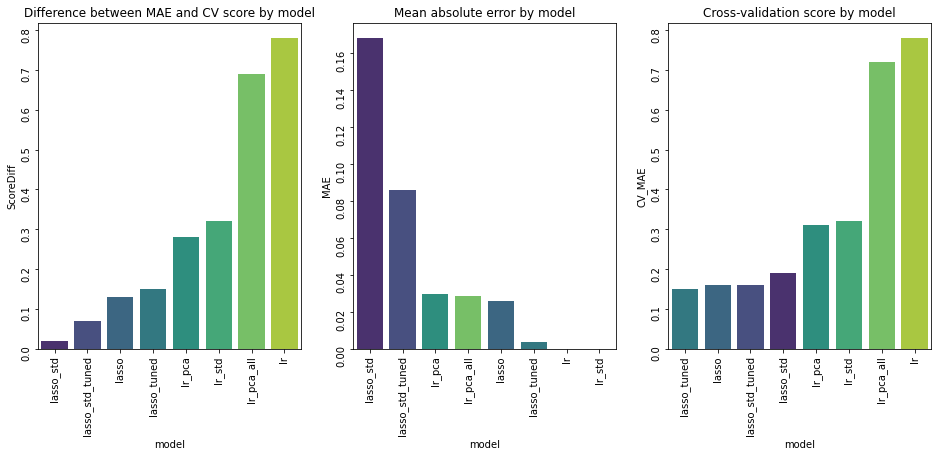

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

sns.barplot(data=metrics,
            x='model',
            y='ScoreDiff', 
            order=metrics.sort_values(by=['ScoreDiff'], ascending=True).set_index('model').index,
            palette=colours,
            ax=axes[0])

sns.barplot(data=metrics,
            x='model',
            y='MAE', 
            order=metrics.sort_values(by=['MAE'], ascending=False).set_index('model').index,
            palette=[colours[i] for i in [0, 1, 4, 6, 2, 3, 7, 5]],
            ax=axes[1])

sns.barplot(data=metrics,
            x='model',
            y='CV_MAE', 
            order=metrics.sort_values(by=['CV_MAE'], ascending=True).set_index('model').index,
            palette=[colours[i] for i in [3, 2, 1, 0, 4, 5, 6, 7]],
            ax=axes[2])

axes[0].tick_params(labelrotation=90)
axes[1].tick_params(labelrotation=90)
axes[2].tick_params(labelrotation=90)
axes[0].set_title('Difference between MAE and CV score by model')
axes[1].set_title('Mean absolute error by model')
axes[2].set_title('Cross-validation score by model')
plt.show()

In [37]:
print(metrics)

             model           MAE  CV_MAE  ScoreDiff
0               lr  9.580000e-16    0.78       0.78
1           lr_std  2.430000e-16    0.32       0.32
2           lr_pca  2.940000e-02    0.31       0.28
3       lr_pca_all  2.860000e-02    0.72       0.69
4            lasso  2.580000e-02    0.16       0.13
5        lasso_std  1.680000e-01    0.19       0.02
6      lasso_tuned  3.860000e-03    0.15       0.15
7  lasso_std_tuned  8.580000e-02    0.16       0.07


## 7.3 Model performance comparison

Overall, the models performed best in the following order: tuned LASSO > LASSO > PCA > linear regression.

* As stated previously, the best models for fitting all 8 samples exactly are the inear regression modelss which use all possible predictors. Although they technically provide the best answer to the assignment, these models have no meaning and provide no explainability.


* When considering the difference between the MAE and CV_MAE as a metric for detecting overfitting, the best performing model is lasso_std, with almost equal MAE and CV_MAE. However, as seen above, this model includes none of the predictors and only fits the targets using the intercept. The fact that the LASSO regressor set all predictors to 0 is probably a symptom of the sample size being too small to be fit efficiently. Furthermore, it is only the 4th best model at predicting unseen targets, and it is by far the worst model at fitting all 8 targets, which is the baseline assignment. For these reasons, let's look further to find the "best simplest model" we are looking for.


* The model that performs best at predicting unseen targets (for which CV_MAE is smallest) is the lasso_tuned model. This model performs exceedingly well at fitting the training data as well, with an even lower MAE, an indication that the model is still overfit to the training dataset, although, as stated above, this is almost impossible to achieve given the very small sample size and the large variance in the samples.


* Other contenders for the "best simplest model" are the regular LASSO model (lasso) and the tuned and standardised LASSO model (lasso_std_tuned), which are second and third best at minimising the difference between MAE and CV_MAE, are good at fitting the provided targets and are almost as good as the lasso_std model at predicting unseen targets. The biggest difference is that they perform worse at fitting the 8 targets (higher MAE) than lasso_tuned. This may be an indication that lasso_tuned overfits the targets more than the other models.

## 7.4 "Best simplest model"

The "best simplest model" fit in this exercise is among the lasso_tuned, lasso and lasso_std_tuned models. The "best simplest model" will be determined based on 3 arguments: metrics, simplicity and explainability.

### The metrics argument


From the metrics point of view, all three models perform equally well on predicting unseen samples as indicated by their low cross- validation scores (low CV_MAE). The lasso_tuned model obtains the best fit to the 8 targets, followed by the lasso and the lasso_std_tuned model, which is the worst. However, this is an indication that the lasso_tuned model is the least overfit, leading to a lower MAE - CV_MAE difference. 

Overall, the **lasso_tuned** model performs best metrics-wise, followed by the lasso model, and then the lasso_std_tuned model.

In [38]:
print(metrics[metrics.model.isin(['lasso_tuned', 'lasso', 'lasso_std_tuned'])])

             model      MAE  CV_MAE  ScoreDiff
4            lasso  0.02580    0.16       0.13
6      lasso_tuned  0.00386    0.15       0.15
7  lasso_std_tuned  0.08580    0.16       0.07


### The simplicity argument

From the simplicity point of view, the lasso_std_tuned model is the simplest of the models, using only 3 predictors for similar goodness of fit and cross-validation scores. The lasso model includes only 4 predictors and is the second simplest. The lasso_tuned model contains 422 features and is by far the most complex model. A case can also be made for the lasso model that is simpler from the modelling perspective, if computing time becomes an issue with larger datasets. 

Overall, the **lasso_std_tuned** is the simplest model, followed by lasso and lasso_tuned.

In [39]:
print(f'The tuned LASSO model includes {best_lasso.coef_[best_lasso.coef_ != 0].shape[0]} non-zero coefficients')
print(f'The base LASSO model includes {lasso.coef_[lasso.coef_ != 0].shape[0]} non-zero coefficients')
print('The tuned and standardised LASSO model includes',
      best_lasso_std.named_steps['lasso'].coef_[best_lasso_std.named_steps['lasso'].coef_ > 0].shape[0],
      'non-zero coefficients')

The tuned LASSO model includes 422 non-zero coefficients
The base LASSO model includes 4 non-zero coefficients
The tuned and standardised LASSO model includes 3 non-zero coefficients


### The explainability argument

Explainability is an important metric of a linear model since such models allow to determine easily which predictors contribute most to its fit. The top 5 features of both models are detailed to assess their link with the target.

The 5 top features of the lasso_tuned model are:
\[List anonymised\]

\[Explanation anonymised\]

The 3 features of the lasso_std_tuned model are:
\[List anonymised\]

\[Explanation anonymised\]

The 4 features of the lasso model are:
\[List anonymised\]

\[Explanation anonymised\]

\[Explanation anonymised\] The **lasso_tuned** is by far the most easily interpretable.

In [40]:
print(important_features[['lasso', 'lasso_tuned', 'lasso_std_tuned']].head())

        lasso lasso_tuned lasso_std_tuned
0   Feature66   Feature16      Feature974
1   Feature80   Feature17      Feature983
2  Feature667   Feature14     Feature1047
3  Feature187   Feature23             NaN
4         NaN   Feature19             NaN


### Overall, 

* The **lasso_tuned** model provides a very good fit to the target data and performs the best at predicting unseen targets.
* The **lasso_std_tuned** model is simpler since it based on only 3 features, which is an indication of its lack of overfitting
* The **lasso_tuned** model is easier to interpret since it is based on \[explanation anonymised\]

The “best simplest model” fit in this exercise is lasso_tuned, a LASSO regressor with tuned hyperparameters using a GridSearchCV resulting in: alpha=0.001, fit_intercept=False, max_iter=100, normalize=True, tol=0.1. The mean absolute error of this model to fit the 8 targets is about 0.004. The cross-validation mean absolute error obtained by this model, a metric of how well the model should be able to fit unseen samples (and therefore to have captured the true variance of the data) is 0.15. This model is likely overfit to the data given its 422 features and very low fit mean absolute error, but fits the targets very well and performs the best when predicting the target of samples left out of the dataset. Furthermore, its features are easily interpretable which makes it more explanable than the other models.

In [41]:
print(best_lasso)

Lasso(alpha=0.001, fit_intercept=False, max_iter=100, normalize=True, tol=0.1)


If the purpose of the model would have been to predict the targets of new samples, the lasso_std_tuned would likely produce equally good (or bad) results for seen and unseen samples, with a cross-validation MAE of 0.16, but would perform poorly on the provided targets, with an MAE of about 0.085, and is less interpretable than lasso_tuned.

In [42]:
print(best_lasso_std.named_steps['lasso'])

Lasso(alpha=0.1, max_iter=100, normalize=False, tol=0.01)


# Other options to consider

Further feature selection methods could be explored, such as 
* Attempting simple linear regression based on the top LASSO features
* Decision tree based on the top LASSO features (to avoid overfitting)
* Forward and Backward feature selection using SequentialFeatureSelector
* SelectFromModel combined with LinearSVC
* Univariate feature selection based on statistical correlation (e.g. SelectKBest)
* Explore the impact of the order of samples in the DataFrame on LASSO regression results